## Checking the Qutip Code

#### Imports and Data

In [179]:
from src.qutip_lab.qutip_class import SpinOperator, SpinHamiltonian, SteadyStateSolver
import numpy as np
import qutip
from tqdm import tqdm, trange
from typing import Dict, List, Tuple, Union
import matplotlib.pyplot as plt

# size of the system
size: int = 8

# periodic boundary conditions
pbc: bool = True

# fix the random seed
np.random.seed(12)

# coupling term
j: float = 1.

#time 
tf=10.
dt=0.001


# time interval
t_resolution: int = int(tf / dt)
t: np.ndarray = np.linspace(0, tf, t_resolution)
print(t_resolution)
h0=5.
hf=0.
rate=1


10000


#### Create the time independent Hamiltonian and the Initial state

In [168]:
ham0 = SpinHamiltonian(
            direction_couplings=[("z", "z")],
            field_directions=[("x"), ("z")],
            pbc=True,
            coupling_values=[1.],
            field_values=[1.0, 0.],
            size=size,
        )

hamExt=SpinHamiltonian(
            field_directions=[("z")],
            pbc=True,
            field_values=[h0],
            size=size,
        )

#print(ham0.qutip_op)


eng, psi0 = np.linalg.eigh(ham0.qutip_op+hamExt.qutip_op)
psi0=psi0[:,0]

psi0 = qutip.Qobj(
            psi0, shape=psi0.shape, dims=([[2 for i in range(size)], [1]])
        )



Hermitian Check positive! well done! 

Hermitian Check positive! well done! 

Hermitian Check positive! well done! 



#### Build the Local observable

In [169]:
obs: List[qutip.Qobj] = []
obs_x: List[qutip.Qobj] = []
for i in range(size):
    z_op = SpinOperator(index=[("z", i)], coupling=[1.0], size=size, verbose=1)
    # print(f"x[{i}]=", x.qutip_op, "\n")
    x_op = SpinOperator(index=[("x", i)], coupling=[1.0], size=size, verbose=1)
    print(z_op.expect_value(psi=psi0))
    obs.append(z_op.qutip_op)
    obs_x.append(x_op.qutip_op)

-0.9923032673575599
-0.9923032673575599
-0.9923032673575599
-0.9923032673575599
-0.9923032673575599
-0.9923032673575599
-0.9923032673575599
-0.9923032673575599


#### Let's make the Driving class

In [170]:
class DrivingUniformAnnealing:
    def __init__(
        self,
        t_final: float,
        hf: float,
        h0:float,
        rate: float,
    ) -> None:
        self.tf: float = t_final
        self.h0: float = h0
        self.hf:float= hf
        self.rate = rate

    def field(self, t: float, args) -> Union[np.ndarray, float]:
        f_t = np.exp(-1*rate*t)
        return self.hf+ (self.h0-self.hf) * f_t

#### Evolution

In [171]:
t: np.ndarray = np.linspace(0, tf, t_resolution)


h_qutip=np.zeros((t_resolution,size))
ham=[ham0.qutip_op]
for i in range(size):
    driving = DrivingUniformAnnealing(
                t_final=tf,
                h0=h0,
                hf=hf,
                rate=rate,
            )
    h_qutip[:,i]=hf+(h0-hf)*(np.exp(-1*rate*t))
    ham.append([obs[i], driving.field])
output = qutip.sesolve(ham, psi0, t, e_ops=obs + obs_x)

z_qutip=np.zeros((t_resolution,size))
for i in range(size):
        z_qutip[:,i] = output.expect[i]
        
    

#### Visualization

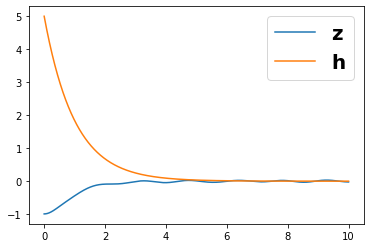

In [172]:
plt.plot(t,z_qutip[:,0],label=r'$\mathbf{z}$')
plt.plot(t,h_qutip[:,0],label=r'$\mathbf{h}$')
plt.legend(fontsize=20)
plt.show()

## Compare the Qutip Result with the Crack-Nicholson algorithm

#### Imports and Data (we need to use a different Environment)

In [173]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from src.tddft_methods.adiabatic_tddft import AdiabaticTDDFT

h_torch=torch.from_numpy(h_qutip)

Initial state configuration

In [174]:
psi=torch.zeros(size=(1,size,2),dtype=torch.complex128)
psi[:,:,1]=1.
psi[:,:,0]=0.

print(psi[:,:,0]**2-psi[:,:,1]**2)

tensor([[-1.+0.j, -1.+0.j, -1.+0.j, -1.+0.j, -1.+0.j, -1.+0.j, -1.+0.j, -1.+0.j]],
       dtype=torch.complex128)


Load the Model

In [175]:
model=torch.load('model_rep/kohm_sham/uniform/model_zzxz_reduction_150k_unet_l_train_8_[40, 40, 40, 40, 40, 40]_hc_5_ks_1_ps_6_nconv_0_nblock',map_location='cpu')
model.eval()
print(model)

TDDFTadiabaticModel(
  (conv_downsample): ModuleList(
    (0): Sequential(
      (conv1): Conv1d(1, 40, kernel_size=(5,), stride=(1,), padding=(2,), padding_mode=circular)
      (activation 1): GELU()
    )
    (1): Sequential(
      (conv2): Conv1d(40, 40, kernel_size=(5,), stride=(1,), padding=(2,), padding_mode=circular)
      (activation 2): GELU()
    )
    (2): Sequential(
      (conv3): Conv1d(40, 40, kernel_size=(5,), stride=(1,), padding=(2,), padding_mode=circular)
      (activation 3): GELU()
    )
    (3): Sequential(
      (conv4): Conv1d(40, 40, kernel_size=(5,), stride=(1,), padding=(2,), padding_mode=circular)
      (activation 4): GELU()
    )
    (4): Sequential(
      (conv5): Conv1d(40, 40, kernel_size=(5,), stride=(1,), padding=(2,), padding_mode=circular)
      (activation 5): GELU()
    )
    (5): Sequential(
      (conv6): Conv1d(40, 40, kernel_size=(5,), stride=(1,), padding=(2,), padding_mode=circular)
      (activation_6): GELU()
    )
  )
  (conv_upsample): 

Evolution (without gradient in order to check the algorithm)

In [182]:
run1=AdiabaticTDDFT(model=model,h=h_torch.unsqueeze(0),omega=1.,device='cpu',with_grad=True)

z_adiabatic=torch.zeros((1,t.shape[0],size))
z_adiabatic[0,0]=0.
grad=torch.zeros_like(z_adiabatic)
f=torch.zeros_like(torch.tensor(t))
for t in t[:-1]:
    #plt.plot(np.real(psi[:,0]))
    psi=run1.time_step(dt=dt,t=t,psi=psi)
    grad[0,int(t/dt)+1,:]=run1.grad
    f[int(t/dt)+1]=run1.f_values
    z_adiabatic[:,int(t/dt)+1,:]=run1.compute_magnetization(psi=psi)

IndexError: tuple index out of range

#### Visualization

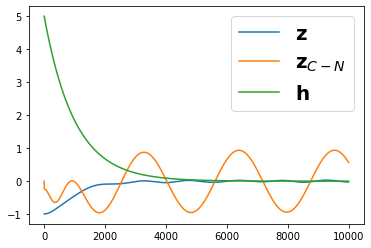

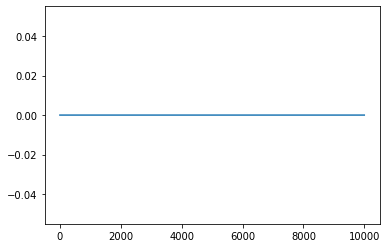

In [181]:
plt.plot(z_qutip[:,0],label=r'$\mathbf{z}$')
plt.plot(z_adiabatic[0,:,0].detach().numpy(),label=r'$\mathbf{z}_{C-N}$')
plt.plot(h_qutip[:,0],label=r'$\mathbf{h}$')
plt.legend(fontsize=20)
plt.show()

plt.plot(grad[0,:,0])
plt.show()

We need to check the behaviour of the Functional Derivative during the whole evolution

## Comparison with a Dataset of N instances

Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt


Data

In [2]:
data=np.load('data/AdTDDFT_results/AdTDDFT_uniform_070623.npz')

z=data['density']
z_target=data['density_target']
h=data['potential']
grad=data['gradient']
f=data['F']

l=z.shape[-1]
rate=np.linspace(0,3,z.shape[0])
time=np.linspace(0,10,z.shape[1])


Visualization

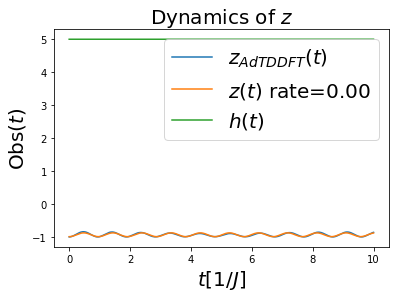

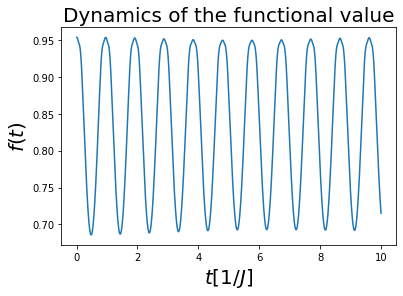

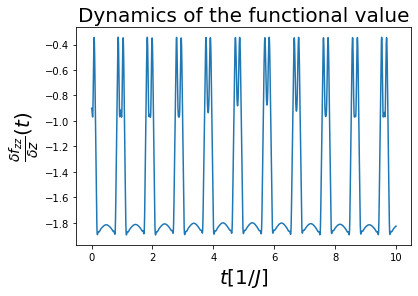

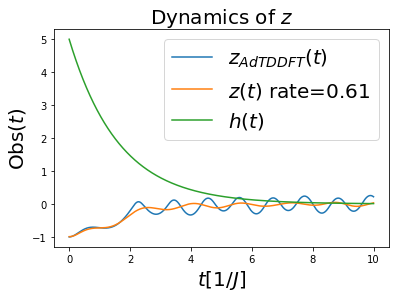

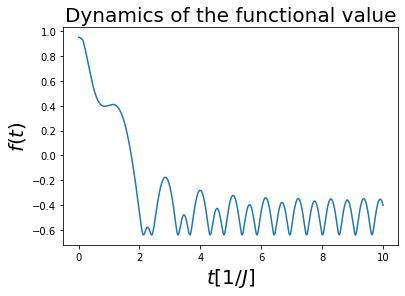

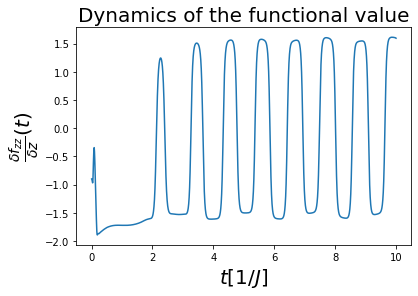

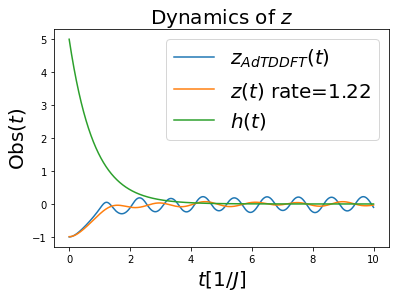

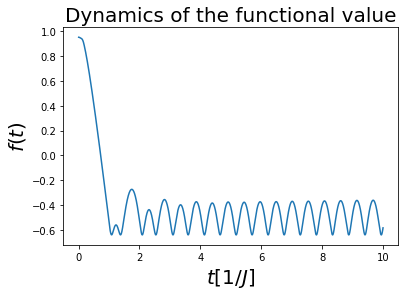

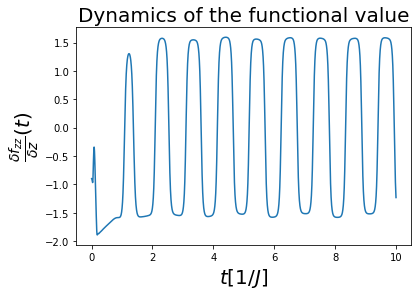

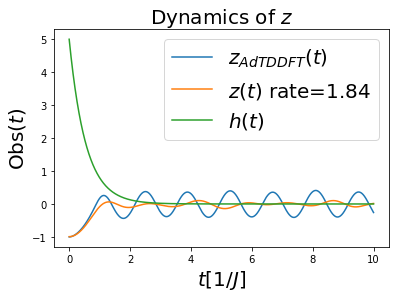

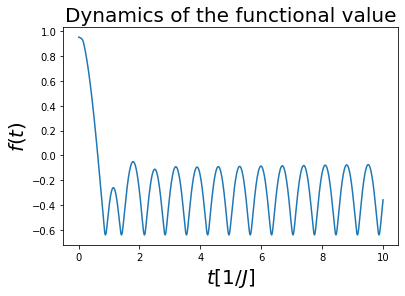

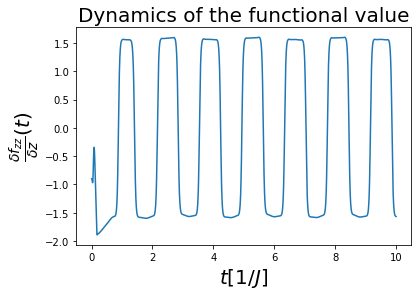

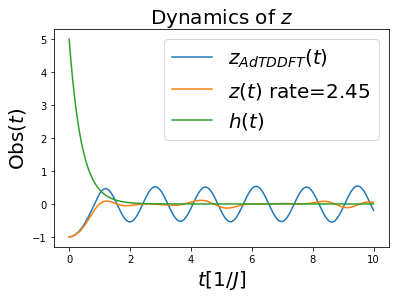

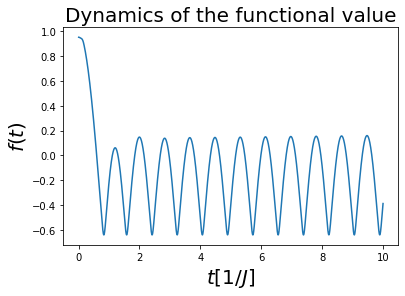

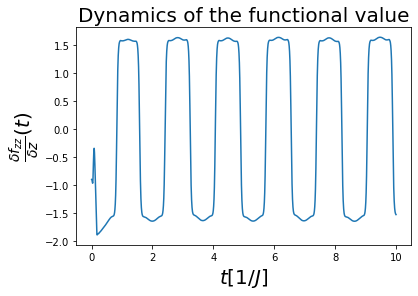

In [9]:
for i in range(0,50,10):
    plt.title(r'Dynamics of $z$',fontsize=20)
    plt.plot(time[2:],z[i,2:,0],label=r'$z_{AdTDDFT}(t)$')
    plt.plot(time[2:],z_target[i,2:,0],label=r'$z(t)$'+f' rate={rate[i]:.2f}')
    plt.plot(time,h[i,:,0],label=r'$h(t)$')
    plt.legend(fontsize=20)
    plt.xlabel(r'$t [1/J]$',fontsize=20)
    plt.ylabel(r'$\mathrm{Obs}(t)$',fontsize=20)
    plt.show()
    
    plt.title('Dynamics of the functional value',fontsize=20)
    plt.plot(time[2:],f[i,2:]/l)
    plt.xlabel(r'$t[1/J]$',fontsize=20)
    plt.ylabel(r'$f(t)$',fontsize=20)
    plt.show()
    
    plt.title('Dynamics of the functional value',fontsize=20)
    plt.plot(time[2:],grad[i,2:,0])
    plt.xlabel(r'$t[1/J]$',fontsize=20)
    plt.ylabel(r'$\frac{\delta f_{zz}}{\delta z}(t)$',fontsize=20)
    plt.show()


#### Compare the results with two different initial states (Experiment)

Imports

In [58]:
import numpy as np
import matplotlib.pyplot as plt

Data

In [59]:
data=np.load('data/AdTDDFT_results/AdTDDFT_uniform_060623.npz')

z_xbase=data['density']
z_target=data['density_target']
h=data['potential']
grad_xbase=data['gradient']
f_xbase=data['F']

data=np.load('data/AdTDDFT_results/AdTDDFT_uniform_070623_complex_initial_state.npz')

z_ybase=data['density']
z_target=data['density_target']
h=data['potential']
grad_ybase=data['gradient']
f_ybase=data['F']



l=z.shape[-1]
rate=np.linspace(0,3,z.shape[0])
time=np.linspace(0,10,z.shape[1])

Visualization

In [ ]:
for i in range(0,50,5):
    plt.title(r'Dynamics of $z$',fontsize=20)
    plt.plot(time,z_ybase[i,:,0]*0.5+z_xbase[i,:,0]*0.5,label=r'$z_{AdTDDFT}(t)')
    plt.plot(time,z_target[i,:,0],label=r'$z(t)$')
    plt.plot(time,h[i,:,0],label=r'$h(t)$')
    plt.xlabel(r'$t [1/J]$',fontsize=20)
    plt.ylabel(r'$\mathrm{Obs}(t)$',fontsize=20)
    plt.show()
    
    plt.title('Dynamics of the functional value',fontsize=20)
    plt.plot(time[2:],f_ybase[i,2:]/l)
    plt.xlabel(r'$t[1/J]$',fontsize=20)
    plt.ylabel(r'$f(t)$',fontsize=20)
    plt.show()
    
    plt.title('Dynamics of the functional value',fontsize=20)
    plt.plot(time[2:],grad_ybase[i,2:,0])
    plt.xlabel(r'$t[1/J]$',fontsize=20)
    plt.ylabel(r'$\frac{\delta f_{zz}}{\delta z}(t)$',fontsize=20)
    plt.show()